# 1. Introduction and hypothesis

I am a great admirer of Jane Austen's work and have read all her novels. Jane Austen's *Northanger Abbey.* was written to be a direct parody of the popular gothic novels of Austen's time. However, Austen, despite all her critiques of the Regency era novel, also greatly enjoyed reading these novels herself. Kim Wheatley's paper (source: https://www.proquest.com/docview/2433185928/fulltextPDF/FFB93446EE4547AFPQ/1?accountid=10267&sourcetype=Scholarly%20Journals)suggests that in many ways Austen's work does in fact mirror some of the gothic tropes---perhaps Austen is even a sort of "gothic novelist" herself. Wheatley argues that these styles enhance Austen's writing, though, giving her characters and scenes realistic emotions and reactions. Since Austen's novels are largely centered on the female protagonist, her writing gives insight into how females are perceived and portrayed during her time. 

Thus, how different is Austen's writing style from the popular gothic writing style of the time? Through feature extraction and text mining techniques I will explore how closely Austen's writing mirrors the gothic-style writing and obseve whether this largely feminist-lauded writer truly had vastly different expressions from the other popular books of her day. 

### Imports

In [235]:
import os
import re
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import string
import fileinput

import seaborn
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, words
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity

from collections import Counter
from nltk.tokenize import word_tokenize

import spacy

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bethkam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Corpus and Data

The gothic regency novels of Austen are not the most widely-circulated books today. Thus, I decided to focus on the novels of one author who is mentioned several times in Austen's own Northanger Abbey: Ann Radcliffe. Ann Radcliffe is an acclaimed author of her time and regarded to be a pioneer of gothic fiction. Gothic novels were largely considerd to be the lowest level of writing back then, yet Radcliffe was able to elevate gothic fiction to a higher level through her inclusions of original poetry and extensive landscape descriptions (source: https://womensprinthistoryproject.com/blog/post/37). As such, Radcliffe appeared to be an appropriate choice to represent the gothic authors. 

In order to have a more balanced dataset, I chose six of Radcliffe's novels to build a corpus for Radcliffe while using all six of Austen's novels for an Austen corpus. The Austen novels were all sourced from Project Gutenberg (https://www.gutenberg.org/ebooks/search/?query=Jane+Austen&submit_search=Go%21). Four of Radcliffe's novels were also sourced from Project Gutenberg (https://www.gutenberg.org/ebooks/search/?query=Ann+Radcliffe&submit_search=Go%21) and the remaining two novels were webscraped from this website: https://archive.org/search?query=Ann+radcliffe. Since all these books are quite old, they are all no longer protected by copyright.

The datasets created includes the following books:

**Jane Austen** 
* Emma 
* Mansfield Park 
* Persuasion 
* Northanger Abbey 
* Sense and Sensibility 
* Persuasion 

**Ann Radcliffe**
* The Castles of Athlin and Dunbayne  
* A Sicilian Romance 
* The Romance of the Forest 
* The Mysteries of Udolpho 
* A Journey Made in the Summer of 1794 
* The Italian 

### Load all the Data

Here, I will webscrape *The Italian* and *The Castles of Athlin and Dunbayne* since I could not find the books on Project Gutenberg.

In [3]:
#Code repurposed from INFO 2950 homework, Fall '22, David Mimno and Allison Koenecke 
def book_scraper(url, book_name):
    book_url = url 
    book_result = requests.get(book_url) 
    if book_result.status_code != 200: 
        print("Something is very wrong:", book_result.status_code, book_result.reason) 
    html_file_path = f'{book_name}.html'
    with open(f'{book_name}.html', 'w') as writer: 
        writer.write(book_result.text.encode('utf8').decode('ascii', 'ignore'))
    with open(f'{book_name}.html', "w") as writer:
        writer.write(book_result.text)
    with open(f'{book_name}.html', "r") as reader:
        html_source = reader.read()
    book_page = BeautifulSoup(html_source, "html.parser")
    full_book = book_page.find_all("pre") 

    for page in full_book:
        pages = page.text
    pages = full_book[:7]
    scraped_data = str(pages)
    with open(f'{book_name}.txt', "w", encoding="utf-8") as file:
        file.write(scraped_data)
    txt_file_path = f'{book_name}.txt'
    with open(txt_file_path, "w", encoding="utf-8") as file:
        file.write(scraped_data)

    print(f'Successfully saved HTML to {html_file_path}')
    print(f'Successfully saved TXT to {txt_file_path}')

In [157]:
book_scraper("https://archive.org/stream/bim_eighteenth-century_the-italian-or-the-conf_radcliffe-ann-ward_1797_1_0/bim_eighteenth-century_the-italian-or-the-conf_radcliffe-ann-ward_1797_1_0_djvu.txt", "italian-1")
book_scraper("https://archive.org/stream/bim_eighteenth-century_the-italian-or-the-conf_radcliffe-ann-ward_1797_2_0/bim_eighteenth-century_the-italian-or-the-conf_radcliffe-ann-ward_1797_2_0_djvu.txt", "italian-2")
book_scraper("https://archive.org/stream/bim_eighteenth-century_the-italian-or-the-conf_radcliffe-ann-ward_1797_3_0/bim_eighteenth-century_the-italian-or-the-conf_radcliffe-ann-ward_1797_3_0_djvu.txt", "italian-3")

Successfully saved HTML to italian-1.html
Successfully saved TXT to italian-1.txt
Successfully saved HTML to italian-2.html
Successfully saved TXT to italian-2.txt
Successfully saved HTML to italian-3.html
Successfully saved TXT to italian-3.txt


In [98]:
book_scraper("https://archive.org/stream/bim_eighteenth-century_the-castles-of-athlin-an_radcliffe-ann-ward_1793/bim_eighteenth-century_the-castles-of-athlin-an_radcliffe-ann-ward_1793_djvu.txt", "Castles")

Successfully saved HTML to Castles.html
Successfully saved TXT to Castles.txt


During the regency era, novels were in "volumes." Thus, I had to combine the separate volumes for *The Italian* and *The Castles of Athlin and Dunbayne* into two complete books.

In [4]:
Italian_txts = ['italian-1.txt', 'italian-2.txt', 'italian-3.txt']

In [5]:
#create function to combine all txt files 
#sourced from: https://stackoverflow.com/questions/13613336/how-do-i-concatenate-text-files-in-python
def combine_txts(txt_files, folder, name):
    with open(f'./{folder}/{name}', 'w') as outfile:
        for fname in txt_files:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)

In [6]:
combine_txts(Italian_txts, "Radcliffe", "Italian.txt")

Now for some text preprocessing. I stripped off all the punctuation from the two Radcliffe novels.

In [8]:
def strip_punctuation(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        content = file.read()
        
    punctuation = str.maketrans('', '', string.punctuation)
    stripped_content = content.translate(punctuation)

    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(stripped_content)

In [9]:
strip_punctuation('./Radcliffe/Italian.txt', 'Italian_no_punct.txt')

In [10]:
strip_punctuation('./Radcliffe/Castles.txt', 'Castles_no_punct.txt')

In [11]:
italian = os.path.join('.',' ', 'Italian_no_punct.txt') 

*The Italian* had an odd character in place of 's' so I had to replace all instances of the character with 's'.

In [12]:
italian = [word.replace('ſ','s') for word in italian]

In [13]:
italian_str = str(italian)

In [14]:
letters = re.compile('[^A-Za-z]')
italian_clean = ''
with open('Italian_no_punct.txt','r',encoding="utf-8") as f:
    content = f.read()
    for char in content:
        char = char.replace('ſ', 's')
        italian_clean += char
    italian_clean = letters.sub(' ', italian_clean)

    
with open('Italian_no_punct.txt',"w+",encoding="utf-8") as f:
    f.write(italian_clean)

Here, I did a check to see how *The Italian* looked after the initial preprocessing. 

In [15]:
print(italian_clean[:400])

He wrapt in clouds of mystery and filence  Broods ver his passions bodies them in deeds  And sends them forth on wings of Fate to others  Like the invisible Will chat guides us   Unheard unknown unsearchable    Aron the year      fome English  travellers in Italy during one of their ex  cursions in the environs of Naples hap  pened to stop before the portico of the  Santa Maria del Pianto a church


The same process took place for Radcliffe's novel *The Castles of Athlin and Dunbayne*.

In [16]:
castles = os.path.join('.',' ', 'Castles_no_punct.txt') 
castles = [word.replace('ſ','s') for word in castles]
castles_str = str(castles)

In [17]:
letters = re.compile('[^A-Za-z]')
castles_clean = ''
with open('Castles_no_punct.txt','r',encoding="utf-8") as f:
    content = f.read()
    for char in content:
        char = char.replace('ſ', 's')
        castles_clean += char
    castles_clean = letters.sub(' ', castles_clean)

    
with open('Castles_no_punct.txt',"w+",encoding="utf-8") as f:
    f.write(castles_clean)

Here, I checked to see how the novel looked. Further preprocessing will take place later. 

In [18]:
print(castles_clean[:900])

prer    ET         lt      RN       P        n         A he    l      r    ET         lt      RN       P        n         A he    l      CASTLES    ATHLIN any DUNBAYNE    THE     CASTLES    ATHLIN any DUNBAYNE       HIGHLAND STORY            FOR JUSTCE BARES THE ARM or cop  AND THE GRASPD VENGEANCE ONLY WAITS HIS NOD    CAWTHs     The Second Edition    A    LONDON    PRINTED FOR HOOKHAM AND CARPENTER  BONDSTREET         N Oo c xciII    THE    CASTLES    O F    ATHLIN any DUNBAYNE    N the northeast coast of Scotland  Ein the most romantic part of the  Highlands stood the castle of Athlin  an edifice built on the summit of a  rock whose base was in the fea This  pile was venerable from its antiquity  and from its gothic structure but more  venerable from the virtues which it  enclosed It was the residence of the        beautiful widow and the children  B of          of the noble Earl of A


Here, I combined the two volumes of Radcliffe's *A Journey Made in the Summer of 1794*.

In [19]:
journey_summer = ['journey-summer-1-cleaned.txt', 'journey-summer-vol2-cleaned.txt']

In [20]:
combine_txts(journey_summer, "Radcliffe", "Journey-summer.txt")

Now, I loaded in all Austen's texts that were downloaded from Project Gutenberg using the function load_austen(). Originally, I created a function to strip the headers from Austen's novels, but all the headers were in different places on the novels. Thus, it was faster for me to manually strip the headers from the raw .txt files. All 6 of Austen's cleaned texts are uploaded under the folder "Austen." The four books from Radcliffe that were also downloaded from Project Gutenberg were cleaned in the same way and stored under the folder "Radcliffe-2." 

In [21]:
#Load Austen texts 
austen_novels = []
def load_austen(path, novel_lst):
    
    for doc in os.listdir(path):
        if os.path.isfile(os.path.join(path, doc)):
            with open(os.path.join(path, doc), "r", encoding='utf-8') as files:
                novel_lst.append(files.read())
                # years.append(int(doc.split('_')[0]))
    print(f"Number of novels: {len(novel_lst)}")

Here are the six Austen novels.

In [22]:
# load_austen("./info-3350/Final Project/Austen")
load_austen("/Users/bethkam/info-3350/Final-Project/Austen/", austen_novels)

Number of novels: 6


In [23]:
#print(austen_novels[5])

In [24]:
#Load the rest of radcliffe's novels
radcliffe_novels = []
load_austen("/Users/bethkam/info-3350/Final-Project/Radcliffe-2/", radcliffe_novels)

Number of novels: 4


In [25]:
additional = [italian_clean, castles_clean]
# radcliffe_complete.extend(additional)

In [26]:
radcliffe_novels.extend(additional)

Here are the six Radcliffe novels.

In [27]:
print(len(radcliffe_novels))

6


In [245]:
# print(radcliffe_novels[2])

## Further Processing 

Now that all my books were loaded, I did further preprocessing for my dataset. First, when I examined some of the raw Austen files, I noticed that a lot of underscores were present so I removed those first.

In [48]:
austen_even_cleaner = []
for novel in austen_novels:
    austen_even_cleaner.append(novel.replace("_", ' '))
# austen_even_cleaner[4]

Next, Austen's novels all have a lot of character names. Although looking at character names is an interesting aspect of text mining, I chose to remove the names. I want to focus more on the sentiments and word placement in Austen and Radcliffe's names and give a higher-level analysis of these works.

In [31]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [32]:
nlp = spacy.load('en_core_web_sm')

In [33]:
nlp.max_length = 2000000

In [41]:
def extract_names(text):
    doc = nlp(text)
    names = {token.text for token in doc if token.ent_type_ == 'PERSON'}
    
    return list(names)

In [42]:
austen_emma_names = extract_names(austen_even_cleaner[0])

In [49]:
austen_pride_names = extract_names(austen_even_cleaner[1])

In [50]:
austen_sense_names = extract_names(austen_even_cleaner[2])

In [51]:
austen_northanger_names = extract_names(austen_even_cleaner[3])

In [52]:
austen_mansfield_names = extract_names(austen_even_cleaner[4])

In [53]:
austen_persuasion_names = extract_names(austen_even_cleaner[5])

Next, I wanted to make a custom stopword list for Austen. I added some more of the words that do not seem the most indicative of Austen's writing as well as some punctuation marks that were missed earlier when the Austen texts had puncutation removed.

In [274]:
#create custom stopwords for processing Austen 
Austen_stops = stopwords.words('english')
for p in string.punctuation:
    Austen_stops.append(p) 
word_list = ['CHAPTER', 'could', 'every', 'much', 'must', 'one', 'said', 'think',
 'well', 'would', 'good', 'know', 'little', 'might', 'miss', 'mr', 'mrs', 'never', 'nothing', 'soon',
 'though', 'time', 'always', 'day', 'ever', 'first', 'great', 'made', 'may', 'quite', 'say', 'see', 'shall', 'thing', 'thought', 'two',
 'without', 'however', 'indeed', 'sure', 'make', 'way', 'like', 'many', 'arthur', 'surprize', '—', '” “', '’']
Austen_stops.extend(word_list)
Austen_stops.extend(austen_emma_names)
Austen_stops.extend(austen_pride_names)
Austen_stops.extend(austen_sense_names)
Austen_stops.extend(austen_northanger_names)
Austen_stops.extend(austen_mansfield_names)
Austen_stops.extend(austen_persuasion_names)

lower_stop_austen = [word.lower() for word in Austen_stops]

#print(lower_stop_austen)

I also lemmatized the text to have a more consistent representation of the words in Austen's novel. 

In [126]:
def lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

Also, I forgot to remove the punctuation from Austen's novels, so I created a new function for it.

In [267]:
def remove_punctuation(text):
    translator = str.maketrans("", "", string.punctuation)
    text_without_punct = text.translate(translator)
    
    return text_without_punct

In [129]:
emma_lemmatize = lemmatizer(austen_even_cleaner[0])

In [130]:
pride_lemmatize = lemmatizer(austen_even_cleaner[1])

In [131]:
sense_lemmatize = lemmatizer(austen_even_cleaner[2])

In [132]:
northanger_lemmatize = lemmatizer(austen_even_cleaner[3])

In [133]:
mansfield_lemmatize = lemmatizer(austen_even_cleaner[4])

In [137]:
persuasion_lemmatize = lemmatizer(austen_even_cleaner[5])

In [276]:
emma_done = remove_punctuation(emma_lemmatize)

In [269]:
pride_done = remove_punctuation(pride_lemmatize)
sense_done = remove_punctuation(sense_lemmatize)
northanger_done = remove_punctuation(northanger_lemmatize)
mansfield_done = remove_punctuation(mansfield_lemmatize)
persuasion_done = remove_punctuation(persuasion_lemmatize)

Here is the finished list of Austen's novels stored in "austen_complete."

In [271]:
austen_complete = [emma_done, pride_done, sense_done, northanger_done, mansfield_done, persuasion_done]
# print(austen_complete[0])

In [143]:
# austen_lemmatized = [emma_lemmatize, pride_lemmatize, sense_lemmatize, northanger_lemmatize, mansfield_lemmatize, persuasion_lemmatize]
# # austen_lemmatized.extend(emma_lemmatize)

The same processing takes place for Radcliffe's novels. 

In [ ]:
radcliffe_even_cleaner = []
for novel in radcliffe_novels:
    radcliffe_even_cleaner.append(novel.replace("_", ' '))

In [ ]:
rad_sicilian_names = extract_names(radcliffe_even_cleaner[0])

In [ ]:
rad_journey_names = extract_names(radcliffe_even_cleaner[1])
rad_forest_names = extract_names(radcliffe_even_cleaner[2])
rad_udolpho_names = extract_names(radcliffe_even_cleaner[3])
rad_italian_names = extract_names(radcliffe_even_cleaner[4])
rad_castles_names = extract_names(radcliffe_even_cleaner[5])

In [ ]:
#create custom stopwords for processing Radcliffe
Radcliffe_stops = stopwords.words('english')
for p in string.punctuation:
    Radcliffe_stops.append(p) 
word_list = ['prer', 'ET', 'lt', 'RN', 'P', 'n', 'A','he','l', 'r', 'ET', 'lt','RN', 'P', 'n', 'A', 'l', 'CASTLES', 'ATHLIN', 'DUNBAYNE','THE', 'CASTLES', 'HIGHLAND STORY', 'FOR JUSTCE BARES THE ARM', 'or cop  AND THE GRASPD VENGEANCE ONLY WAITS HIS NOD    CAWTHs     The Second Edition    A    LONDON    PRINTED FOR HOOKHAM AND CARPENTER  BONDSTREET         N Oo c xciII    THE    CASTLES    O F    ATHLIN any DUNBAYNE    N ', 'would',
'may', 'might', 'though', 'much', 'without', 'whose', 'could', 'made', 'however', 'said', 'first', 'well', 'yet', 'xciii']
Radcliffe_stops.extend(word_list)
Radcliffe_stops.extend(rad_sicilian_names)
Radcliffe_stops.extend(rad_journey_names)
Radcliffe_stops.extend(rad_forest_names)
Radcliffe_stops.extend(rad_udolpho_names)
Radcliffe_stops.extend(rad_italian_names)
Radcliffe_stops.extend(rad_castles_names)

lower_stop_radcliffe = [word.lower() for word in Radcliffe_stops]

#print(lower_stop_radcliffe)

In [ ]:
sicilian_lemmatize = lemmatizer(radcliffe_even_cleaner[0])
journey_lemmatize = lemmatizer(radcliffe_even_cleaner[1])
forest_lemmatize = lemmatizer(radcliffe_even_cleaner[2])
udolpho_lemmatize = lemmatizer(radcliffe_even_cleaner[3])
italian_lemmatize = lemmatizer(radcliffe_even_cleaner[4])
castles_lemmatize = lemmatizer(radcliffe_even_cleaner[5])

In [ ]:
sicilian_done = remove_punctuation(sicilian_lemmatize)
journey_done = remove_punctuation(journey_lemmatize)
forest_done = remove_punctuation(forest_lemmatize)
udolpho_done = remove_punctuation(udolpho_lemmatize)
italian_done = remove_punctuation(italian_lemmatize)
castles_done = remove_punctuation(castles_lemmatize)

Here is the completed dataset for Radcliffe.

In [ ]:
radcliffe_complete = [sicilian_done, journey_done, forest_done, udolpho_done, italian_done, castles_done]

In [ ]:
# radcliffe_lemmatized = [sicilian_lemmatize, journey_lemmatize, forest_lemmatize, udolpho_lemmatize, italian_lemmatize, castles_lemmatize]

# Methods

Below are all my methods. The results are interpreted along with each different method.

## Tfidf Time

To further characterize the styles of Radcliffe and Austen, I decided to apply TF-IDF vectorization on the two separate works. After that, I interpreted the features and most common words found to see if they appeared relevant to Austen and Radcliffe's writing styles.

In [277]:
austen_vectorizer = TfidfVectorizer(
    stop_words = lower_stop_austen,
    min_df = 0.5, 
    max_features = 30,
    use_idf = False,
    lowercase = True,
)

X = austen_vectorizer.fit_transform(austen_complete)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

print(f"Feature Matrix shape: {X.shape}")
print(f"Mean value: {X_scaled.mean()}")
for i in austen_vectorizer.get_feature_names_out():
    print(i)

feature_names = austen_vectorizer.get_feature_names_out()
print(f"Feature Names: {feature_names}")


term_sums = np.sum(X.toarray(), axis=0)

term_counter = Counter(dict(zip(feature_names, term_sums)))

top_20_terms = term_counter.most_common(20)

print("Most Common 20 Words:")
for term, count in top_20_terms:
    print(term)

Feature Matrix shape: (6, 30)
Mean value: 1.0855514018557086e-16
away
better
come
done
enough
even
family
father
feeling
friend
give
go
ha
hope
last
letter
look
man
manner
mind
moment
mother
oh
room
seemed
sir
sister
upon
wa
wish
Feature Names: ['away' 'better' 'come' 'done' 'enough' 'even' 'family' 'father' 'feeling'
 'friend' 'give' 'go' 'ha' 'hope' 'last' 'letter' 'look' 'man' 'manner'
 'mind' 'moment' 'mother' 'oh' 'room' 'seemed' 'sir' 'sister' 'upon' 'wa'
 'wish']
Most Common 20 Words:
wa
ha
sister
friend
man
sir
feeling
go
father
give
away
hope
room
wish
come
moment
last
mother
even
family


/Users/bethkam/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['add', 'admiration', 'affected', 'alas', 'almane', 'appear', 'appeared', 'behind', 'compliment', 'consciousness', 'detail', 'easily', 'easy', 'go', 'gone', 'greater', 'happy', 'health', 'indignantly', 'infatuation', 'jealousy', 'judge', 'kindness', 'knew', 'known', 'large', 'learn', 'letter', 'mare', 'mean', 'men', 'methodical', 'mine', 'miserable', 'moment', 'motive', 'nobody', 'oh', 'passed', 'plan', 'propriety', 'prosperous', 'quickly', 'ready', 'return', 'right', 'rise', 'sentence', 'sight', 'sir', 'sufficient', 'together', 'understanding', 'upon', 'windows', 'women', 'worse', 'yes'] not in stop_words.
  warnings.warn(


**Intepretation** 

There are have six document and thirty features here. For the features, I would say the ones chosen do in fact largely mirror the style of Austen's writing, especially "letter", "manner", and "feeling." Austen's novels largely focus on the both the internal and external appearances of her characters. In addition, since all her novels center on women, she does discuss the feelings of her protagonists. Letters are common in regency era (and many other eras), but since letters are often a mode of expression in Austen's works, having "letter" as a primary feature to express the feelings of Austen's characters is common and reflected by the vectorization performed. 

For the most common 20 words, I also see a lot of familial terms such as "mother", "family", "sister" and "friend." Again, Austen's works focus a lot on the interactions between characters in relation to external events. Austen's works centers on more "realistic" type of Regency events as well. And since women spend a lot of time with their families until marriage, it also makes sense that these words would be present in the most common ones since Austen's work centered on women who are in the pre-marital state.

In [283]:
radcliffe_vectorizer = TfidfVectorizer(
    stop_words = lower_stop_radcliffe,
    min_df = 0.5, 
    max_features = 30,
    use_idf = False,
    lowercase = True,
)

X_r = radcliffe_vectorizer.fit_transform(radcliffe_complete)

scaler = StandardScaler()
X_r_scaled = scaler.fit_transform(X_r.toarray())

print(f"Feature Matrix shape: {X_r.shape}")
print(f"Mean value: {X_r_scaled.mean()}")
for i in radcliffe_vectorizer.get_feature_names_out():
    print(i)

feature_names = radcliffe_vectorizer.get_feature_names_out()
print(f"Feature Names: {feature_names}")


term_sums = np.sum(X.toarray(), axis=0)

term_counter = Counter(dict(zip(feature_names, term_sums)))

top_20_terms = term_counter.most_common(20)

print("Most Common 20 Words:")
for term, count in top_20_terms:
    print(term)

/Users/bethkam/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amselle', 'another', 'arm', 'aunoy', 'bares', 'belonged', 'bondstreet', 'booty', 'carpenter', 'cawths', 'com', 'cop', 'days', 'edition', 'empire', 'evening', 'finger', 'flit', 'fortune', 'glanc', 'graspd', 'hookham', 'hope', 'justce', 'london', 'mariners', 'ms', 'mselle', 'murd', 'nod', 'occasions', 'oyré', 'pow', 'printed', 'relief', 'replied', 'reply', 'rer', 'retract', 'rob', 'sake', 'served', 'story', 'vengeance', 'waits'] not in stop_words.
  warnings.warn(


Feature Matrix shape: (6, 30)
Mean value: 4.4408920985006264e-17
almost
chamber
circumstance
door
even
every
eye
father
heard
heart
hour
know
left
length
little
man
mind
moment
never
one
part
passed
person
place
scene
seemed
still
thought
till
upon
Feature Names: ['almost' 'chamber' 'circumstance' 'door' 'even' 'every' 'eye' 'father'
 'heard' 'heart' 'hour' 'know' 'left' 'length' 'little' 'man' 'mind'
 'moment' 'never' 'one' 'part' 'passed' 'person' 'place' 'scene' 'seemed'
 'still' 'thought' 'till' 'upon']
Most Common 20 Words:
till
left
still
heart
moment
seemed
heard
know
father
hour
almost
length
place
upon
circumstance
part
little
passed
every
eye


**Interpretation**

There are six documents and 30 features. Interestingly, the features listed here for Radcliffe's work do seem relatively informative of the work. "Chamber", "scene", "and "door" do seem indicative of writing I would expect in a gothic novel, give that gothic novels, especially Radcliffe's works seem to focus a lot on surroundings. Other words such as "heart", "hour" and "mind" could also be indicative of the more passionate feelings or expressions typically found in gothic writing. 

For the most common 20 words, the words are also indicative of potential gothic scenes such as "circumstance" and "hour." That being said, some of the most common words here could be more subject to intepretation. Although I view "passed" as another potential indicator given that it has the dual implication of either time or travel (both of which are typicaly in gothic writing), those words could very well be implying something else. 

Overall, though, I think the features and most common words chosen are pretty reflective of the type of events that characterize the Radcliffe's works. My one slight concern is that it's possible these features and words are characterizing the events of Radcliffe more than her actual writing style---but the two do go hand-in-hand in literature, thus I still believe these featues to still have some merit.

## Sentiment Analysis

Now, I want to analyze the sentiment of the Austen and Radcliffe texts. Since the object of the question if to see how similar Austen's styles are to Radcliffe's, it will be interesting to observe how different (or similar) their sentiment scores will be.

In [223]:
def remove_stopwords(text, stopwords):
    text = ' '.join(text)
    text = text.lower()
    total_words = Counter(word_tokenize(text))
    for stop in stopwords: 
        del total_words[stop] 
    return list(total_words.keys())

In [285]:
austen_sentiments = remove_stopwords(austen_complete, lower_stop_austen)

In [286]:
# print(austen_sentiments)

In [287]:
#The sentiment analyzer is repurposed from INFO 6350 homework, Fa '23, Matthew Wilkens 
def sentiment_analyzer(sentiment, text): 
    string = ' '.join(text)
    
    sentiment_dict = sentiment.polarity_scores(string) 
    overall_sentiment = "" 
    if sentiment_dict["compound"] >= 0.05:
        overall_sentiment = "pos" 
    elif sentiment_dict["compound"] <= 0.05: 
        overall_sentiment = "neg" 
    else:
        overall_sentiment = "neu" 
    sentiment_dict["Overall sentiment"] = overall_sentiment
    return sentiment_dict 

In [288]:
sentiment_object = SentimentIntensityAnalyzer()

In [289]:
sentiment_analyzer(sentiment_object, austen_sentiments)

{'neg': 0.145,
 'neu': 0.713,
 'pos': 0.142,
 'compound': -0.9065,
 'Overall sentiment': 'neg'}

**Intepretation**

Neg: 0.145.
The proportion of negative words in Austen is 14.5%, suggesting a moderate amount of negative sentiment.

Neu: 0.713. 
The proportion of neutral words in the text is 71.3%. Thus, it seems a large portion of Austen's text is neutral. 

Pos: 0.142.
The proportion of positive words in the text is 14.2%, suggesting a medium amount of positive sentiment.

Compound: -0.9065: 
This score is -0.9065, indicating a strongly negative sentiment.

Overall the sentiment of Austen's texts is negative. I am quite surprised by this result. Austen's books in general are not books I would label as "negative" due to the nature of the stories--they all have realistic, witty, sometimes sorrowful, but overall triumphant female leads. Thus, I would have labeled Austen's works as positive or neutral. However, I suspect that since Austen's works largely capture all the too-real aspects of humanity from the good, the bad, and the ugly, then that could lead to an overall negative sentiment score. 

In [290]:
radcliffe_sentiments = remove_stopwords(radcliffe_complete, lower_stop_radcliffe)

In [291]:
sentiment_analyzer(sentiment_object, radcliffe_sentiments)

{'neg': 0.118,
 'neu': 0.773,
 'pos': 0.109,
 'compound': -0.9996,
 'Overall sentiment': 'neg'}

**Interpretation**

Neg: 0.118.
The proportion of negative words in Austen is 11.8%, suggesting a moderate amount of negative sentiment.

Neu: 0.773. 
The proportion of neutral words in the text is 77.3%. Thus, it seems a large portion of Austen's text is neutral. 

Pos: 0.109.
The proportion of positive words in the text is 10.9%, suggesting a medium amount of positive sentiment.

Compound: -0.996: 
This score is -0.996, indicating a strongly negative sentiment.

I am less surprised by this score for Radcliffe's works. Since gothic novels are more characterized by dramatic, tragic events then I would expect Radcliffe's works to have an overall negative sentiment. After all, Ann Radcliffe is famous for "terrifying English private imaginations" (http://www.jstor.org/stable/29533356). 

**Further discussion on Radcliffe and Austen sentiment scores**

Overall, I am surprised that Radcliffe and Austen's sentiment scores are so similar. Granted, both Austen's "positive" score and "negative" score is slightly higher than Radcliffe's. And I expected the larger neutral score since in accordance with the frequent words found in the Tfidf section earlier, a lot of the text in Radcliffe and Austen's works is likely more neutral. Still, give that Radcliffe's works is characterized more by terrifying descriptions and passionate language, I would have also expected higher scores for the amount of positive and negative sentiment. I haven't read Radcliffe's works myself, thus I suspect some close reading of Radcliffe might explain the sentiments observed better. 

### LDA and CountVectorizer() for Austen

The next step was to try applying LDA to see what are the topics present in Austen and Radcliffe's works. I chose to apply this technique to the Austen corpus and Radcliffe corpus separately in order to see what were the individaul topics and whether there appeared to be any similar ones. 

In [292]:
#LDA and CountVectorizer code is repurposed from INFO 6350 homework, Fa '23, Matthew Wilkens
austen_vectorizer_count = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words= lower_stop_austen, # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25   
)

X_austen = austen_vectorizer_count.fit_transform(austen_complete)
print(X_austen.shape)

/Users/bethkam/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['add', 'admiration', 'affected', 'alas', 'almane', 'appear', 'appeared', 'behind', 'compliment', 'consciousness', 'detail', 'easily', 'easy', 'go', 'gone', 'greater', 'happy', 'health', 'indignantly', 'infatuation', 'jealousy', 'judge', 'kindness', 'knew', 'known', 'large', 'learn', 'letter', 'mare', 'mean', 'men', 'methodical', 'mine', 'miserable', 'moment', 'motive', 'nobody', 'oh', 'passed', 'plan', 'propriety', 'prosperous', 'quickly', 'ready', 'return', 'right', 'rise', 'sentence', 'sight', 'sir', 'sufficient', 'together', 'understanding', 'upon', 'windows', 'women', 'worse', 'yes'] not in stop_words.
  warnings.warn(


(6, 5033)


In [293]:
lda = LatentDirichletAllocation(
    n_components=6, #Number of topics to find
    n_jobs=-1,       #Use all CPU cores
    verbose=1,       #Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)
 
lda.fit(X_austen)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(evaluate_every=0, n_components=6, n_jobs=-1,
                          verbose=1)

In [294]:
# Print top words per topic
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [295]:
print_top_words(lda, austen_vectorizer_count.get_feature_names_out(), n_top_words=6, hide_stops=False)

Topic  0: uppercross henrietta lyme norland musgroves cleveland
Topic  1: hertfordshire georgiana shire gardiners lambton nt
Topic  2: contributes imitator strangelooking strained hothouse hothouses
Topic  3: contributes imitator strangelooking strained hothouse hothouses
Topic  4: necklace pumproom udolpho rehearsal crawfords lovers
Topic  5: hartfield surprized campbells charade grandmama martins



In [296]:
def display_topics(model, feature_names, k_top_words, title, n_topics=10):
    fig, axes = plt.subplots(round(n_topics/5), 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-k_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

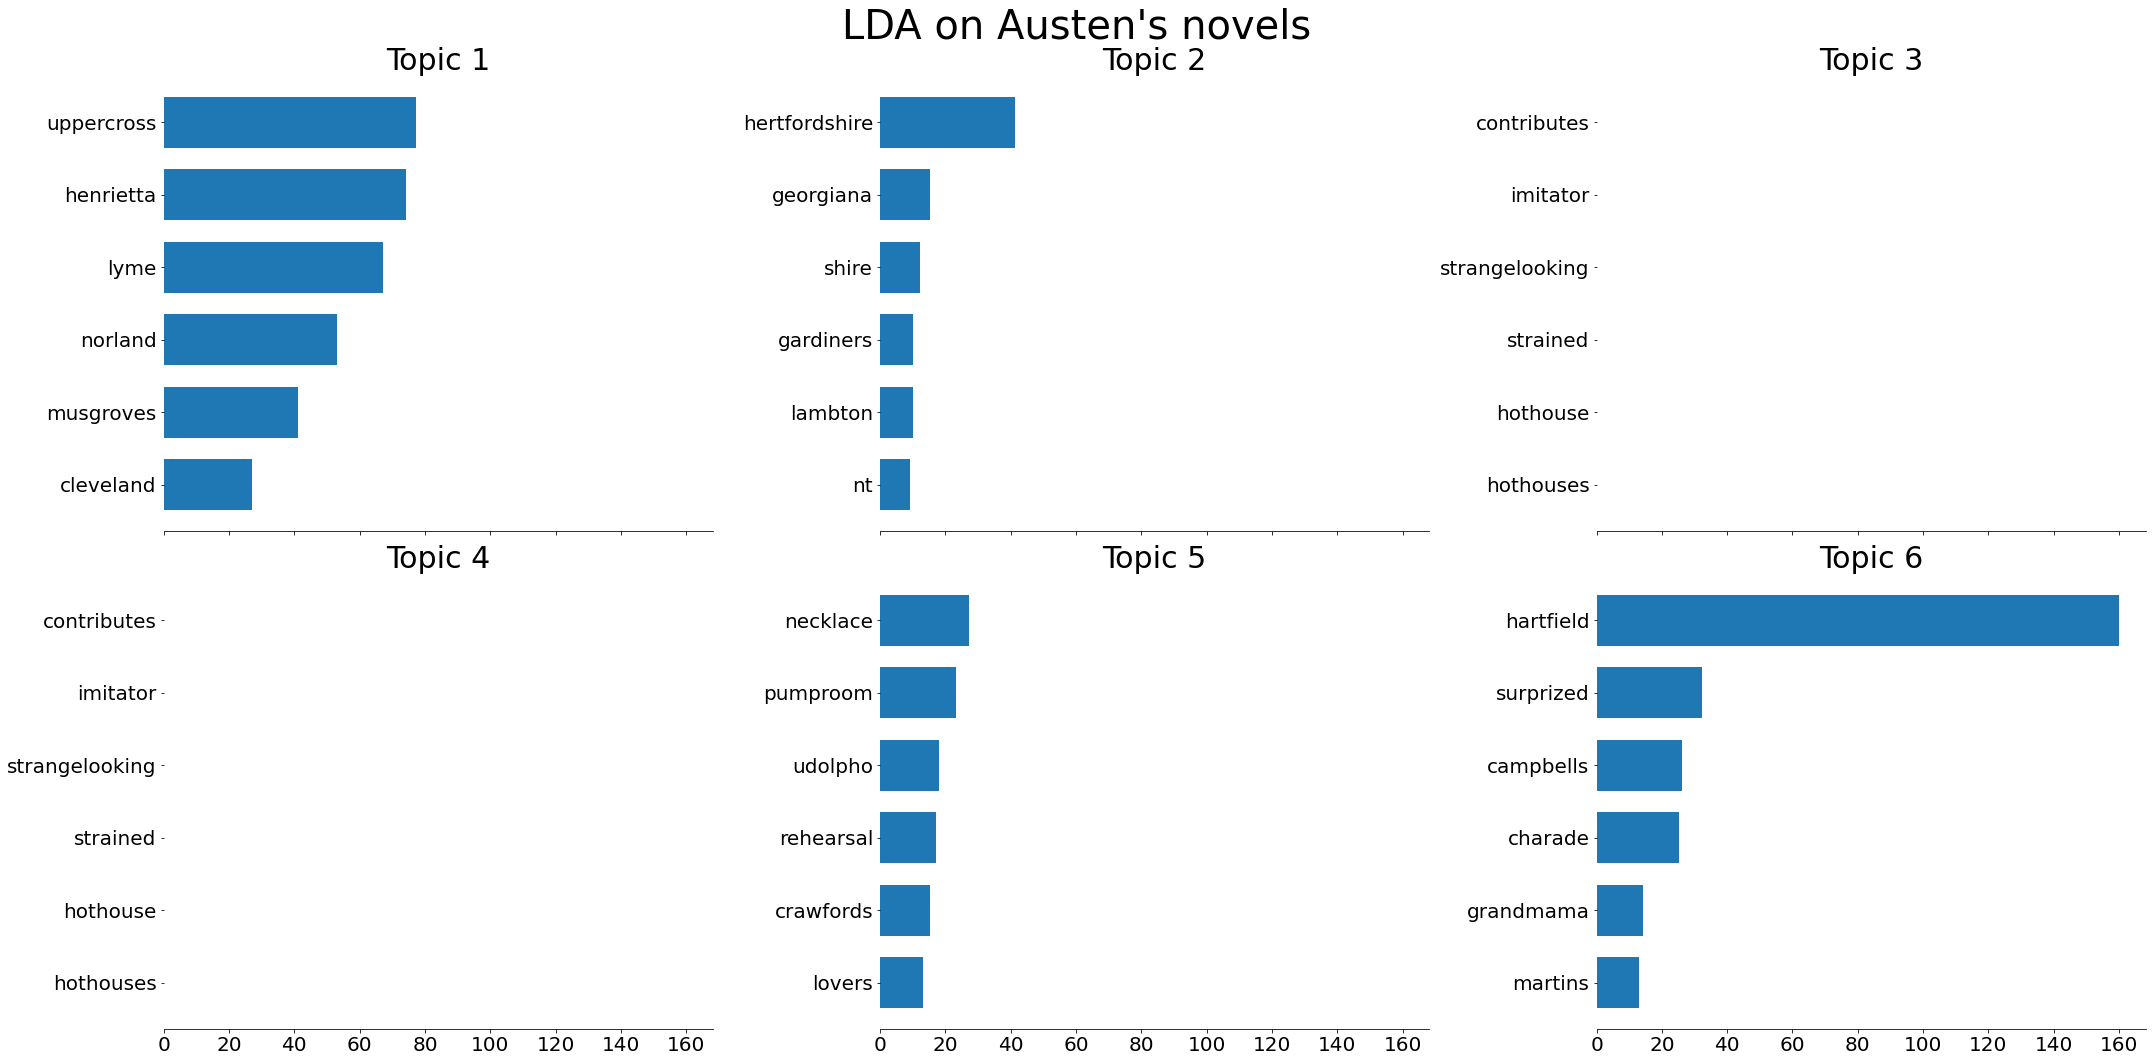

In [297]:
display_topics(lda, austen_vectorizer_count.get_feature_names_out(), 6, "LDA on Austen's novels", 10)

It the topics characterizing Austen's novels are focused more on locations such as "Hertfordshire" and "pumproom." These locations are places where characters frequent. Again, Austen's novels largely center on characters interactions, and each interaction typically does take place in some certain location. For example, *Northanger Abbey* has a lot of scenes taking place in the pumproom. 

From the LDA results, though I can also see some confusion between character names and location names, thus perhaps the name removal from earlier was not able to purify the text entirely. Another point of interest is that I see quite a few words that are specifically from *Emma* and *Mansfield Park.* These two novels are the longest and comprise the most information, thus it's possible the model is slightly biased towards those two books. However, I do see some items in the topic list that reflect *Northanger Abbey* such as the direct mention of "udolpho" which is the name of Radcliffe's novel that is frequnely mentioned in the story. 

Overall, the topics chosen do seem to be reflective of Austen's work.

### LDA and CountVectorizer() for Radcliffe

In [300]:
radcliffe_vectorizer_count = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words= lower_stop_radcliffe, # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25    # Ditto
)

X_radcliffe = radcliffe_vectorizer_count.fit_transform(radcliffe_complete)
print(X_radcliffe.shape)

(6, 11496)


In [301]:
lda = LatentDirichletAllocation(
    n_components=6, #Number of topics to find
    n_jobs=-1,       #Use all CPU cores
    verbose=1,       #Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)
 
lda.fit(X_radcliffe)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(evaluate_every=0, n_components=6, n_jobs=-1,
                          verbose=1)

In [302]:
print_top_words(lda, radcliffe_vectorizer_count.get_feature_names_out(), n_top_words=6, hide_stops=False)

Topic  0: elector dutch cologne holland antient states
Topic  1: edric pannel challenge ardor barons santmorin
Topic  2: ludovico amselle dorothee vallee venice udolpho
Topic  3: 01 annihilates undone despite palpitation pander
Topic  4: sicily favorite palermo elopement calabria marentino
Topic  5: marchese ellenas sche nicola inquisition official



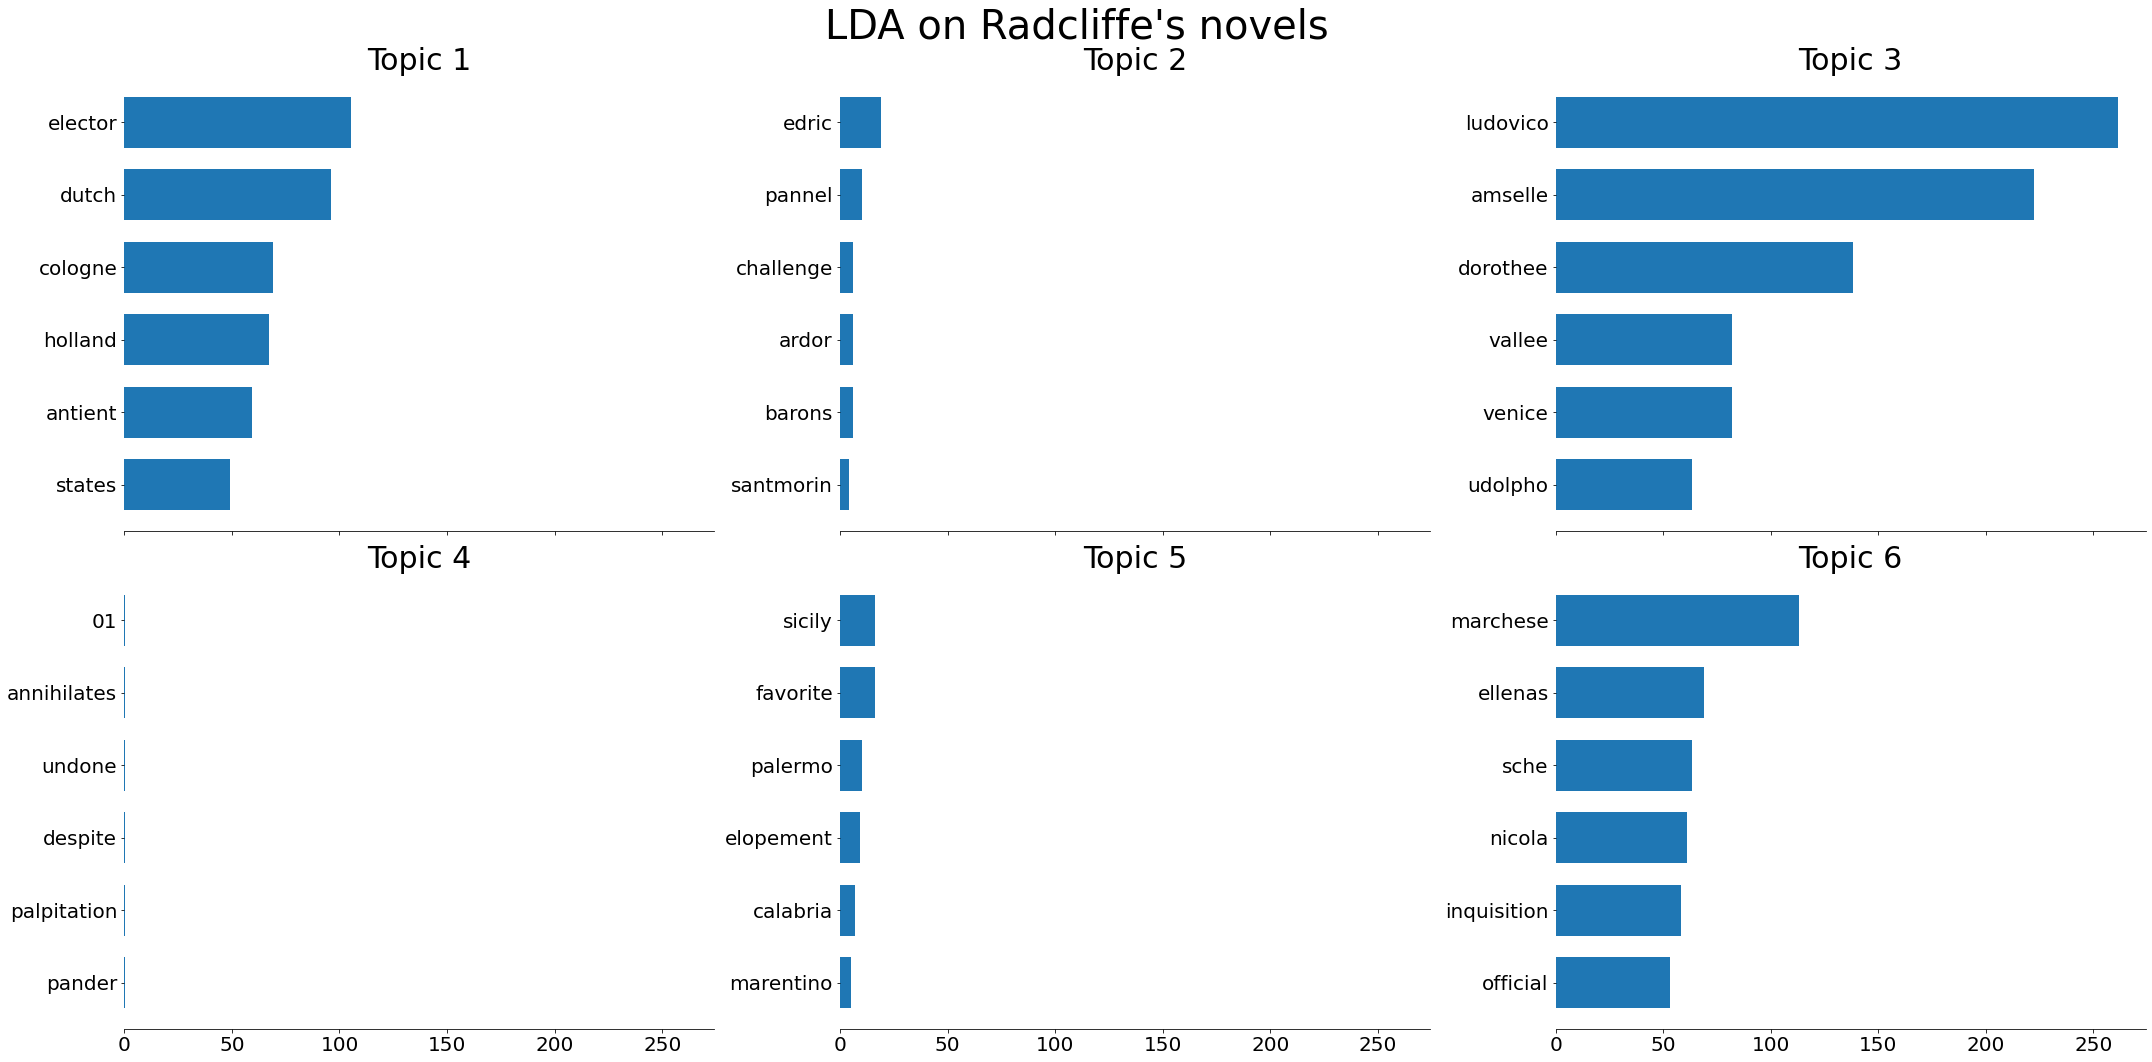

In [303]:
display_topics(lda, radcliffe_vectorizer_count.get_feature_names_out(), 6, "LDA on Radcliffe's novels", 10)

**Intepretation**

I think the same problem occurred here were there is likely some confusion between character and location names which is why some of the topics are being represented by words that are potentially character names. Aside from that, the words representing the topics here are also similar to Austen's in the sense that locations  such as "sicily" and "venice" are also present. Again, I am not really familiar with Radcliffe's works, but words such as "elopment" are also expected in gothich writing. Thus the topics chosen seem representative of Radcliffe. 

**Comparison of Austen and Radcliffe topics**

While the topics for Austen and Radcliffe appear to be different, both are actually focusing on similar things---locations and specific characters (despite my attempt to remove character names). I think this indicates how Austen and Radcliffe's works are likely both people-centered and event-centered (with each event usually being marked by a specific location). This is surprisingly true of Austen's works since Austen's works all focus on ideas that are in relation to one's character. For Radcliffe, more proper names are present in the topics, suggesting that Radcliffe's work is possibly even more location-centric or possibly character-centric. I find this fascinating because I would have expected Radcliffe's work to be more location or event-centric and less character-centric. I also expected Austen's work to be largely character-centric. However, there is a definite overlay between the sets of topics for my two authors.

### Euclidean and Cosine Distances 

Finally, some comparison was needed to be done between Austen and Radcliffe directly. I decided to calculate the Euclidean and Cosine distances between Austen and Radcliffe's works. 

In [304]:
# Merge Austen and Radcliffes novels into one large corpus
austen_radcliffe = austen_complete + radcliffe_complete

In [305]:
# print(austen_radcliffe[10])

In [306]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(austen_radcliffe)
print("\nEuclidean distances")
print(np.round(euclidean_distances(x),2))

print("\nCosine distances")
print(np.round(cosine_distances(x),2))


Euclidean distances
[[    0.    3823.06  4195.33  7220.61  2916.17  6609.76  8091.55 10698.66
   6071.35 18318.36  8413.14  9699.93]
 [ 3823.06     0.    1910.73  4221.07  4381.72  3674.57  5200.65 10410.52
   5655.3  20221.78  9209.2   6594.25]
 [ 4195.33  1910.73     0.    4018.71  4573.42  3574.05  5145.58 10564.71
   5892.17 20480.13  9543.55  6471.84]
 [ 7220.61  4221.07  4018.71     0.    7824.74  1721.09  3370.05 11610.71
   7930.17 23437.37 11964.37  3281.93]
 [ 2916.17  4381.72  4573.42  7824.74     0.    7177.78  8165.35  9800.88
   5126.43 16996.32  7291.2  10078.15]
 [ 6609.76  3674.57  3574.05  1721.09  7177.78     0.    3365.73 11284.26
   7399.35 22855.1  11364.72  3724.9 ]
 [ 8091.55  5200.65  5145.58  3370.05  8165.35  3365.73     0.    9644.37
   6507.65 22155.43 10495.66  2691.69]
 [10698.66 10410.52 10564.71 11610.71  9800.88 11284.26  9644.37     0.
   7314.54 16208.71  6954.4  11676.93]
 [ 6071.35  5655.3   5892.17  7930.17  5126.43  7399.35  6507.65  7314.54
   

Note: our matrices feature all 12 books. 

The order of books for Austen in the matrix is as such: 
- (1) Emma
- (2) Pride and Prejudice
- (3) Sense and Sensibilty
- (4) Northanger Abbey
- (5) Mansfield Park
- (6) Persuasion. 

The order of books for Radcliffe in the matrix is as such: 
- (7) A Sicilian Romance 
- (8) A Journey Made in the Summer of 1794 
- (9) The Romance of the Forest 
- (10) The Mysteries of Udolpho 
- (11) The Italian
- (12) The Castles of Athlin and Dunbayne

**Interpretation of Euclidean Distances**

Since we are comparing Austen to Radcliffe, I will only discuss the distance starting from where Austen and Radcliffe are represented. 

The fourth column represents *Northanger Abbey*. Unexpectedly, Northanger Abbey appears to have one of the largest Euclidean distances from *The Mysteries of Udolpho* (23437.37) and *The Italian* (11964.37). I am quite surprised by this result given that *Northanger Abbey* frequently mentions Radcliffe's *The Mysteries of Udolpho* and *Northanger Abbey* arguably would be the closest to Radcliffe's writing. 

The Austen novel that has the largest Euclidean distances as a whole from Radcliffe is *Emma*. I think this is reasonable given that *Emma* is the most different from all of Austen's others novels. Thus, if Austen's writing as a whole does have parallels to Radcliffe's writing, then it's not surprising that *Emma* would stand out more because it already stands out from Austen's more typical style of novel. 

Both *Pride and Prejudice* and *Sense and Sensibility* have more similar Euclidean distances from Radcliffe's novels. I consider the two works to be more similar, thus it would make sense for them to have similar distances from Radcliffe. These distances were more moderate--some large but not the largest.  

*Persuasion* also has a large Euclidean distance from *The Mysteries of Udolpho* (22855.1). Without a closer reading of this book, I'm not 100% sure of this meaing, but I do know that Persuasion most definitely has some "tragic love" kind of elements to it, thus I would expected this book to have smaller Euclidean distances from Radcliffe. 

Finally, *Mansfield Park* is considered to be the most "serious" of Austen's works. Overall, the Euclidean distances for Mansfield Park are smaller, with the exception of the large Euclidean distance for *The Mysteries of Udolpho* (16996.32) and *The Italian* (10078.15). Overall, I would have expected *Mansfield Park* to have large Euclidean distances from Radcliffe's works. Perhaps, despite the more "moralistic" nature of *Mansfield Park*, the tragic events that do take place in Mansfield Park are enough to shorten the distances between itself and Radcliffe. 

**Interpretation of Cosine Distances**

The Cosine distances are rather small across the board and closer to 0, indicating greater similarity between Austen and Radcliffe's works. 

Both *Northanger Abbey* and *Persuasion* have the smallest Cosine distances, thus they are the closest to Radcliffe's works. This is to be expected of *Northanger Abbey* since this novel has the most gothic elements. As for *Persuasion*, although the protagonist, Anne Elliot, is quite different from my knowledge of gothic female protagonists, *Persuasion* is largely characterized on a more tragic love, thus the small Cosine distances from Radcliffe are not the most surprising. 

Similarly to the Euclidean distance analysis, *Emma* has the largest Cosine distances, indicating greater dissimilarity between this novel and Radcliffe's works. Again, this is to be expected because *Emma* is the most atypical work of Austen's and would stand out more in general.

Again, *Pride and Prejudice* and *Sense and Sensibility* have the same Cosine distances with a mix of larger and smaller values. Similar to before, these two works are closer to one another in writing, thus I would expect them to have the same distances from Radcliffe's works.

**Comparison of Euclidean and Cosine Values**

The analyses for the Euclidean and Cosine distances align except for one point: *Northanger Abbey* unexpectedly differs largely from two gothic novels for Euclidean and is similar in regards to Cosine. This seems rather contradictory since *Northanger Abbey* is the novel that will parallel a gothic work more than any other novel. It is also odd that *Northanger Abbey* had such a large Euclidean distance from *The Mysteries of Udolpho* and the novel that is mentioned frequently in *Northanger Abbey.* 

However, if the Euclidean distance between the Northanger and Udolpho vectors is large, that may mean they differ significantly in terms of words used as well as word frequency. 

In addition, if the cosine distance is small, then that means our two novels share a similar word distribution despites potential differences in length or word count. 

This makes sense because Udolpho is actually Radcliffe's longest work while Northanger Abbey is Austen's shortest one. Thus, the two books are in fact similar with their length differences accounting for the large Euclidean distances. 

# Discussion and conclusions

In conclusion, Radcliffe and Austen's works share quite a few similarities due to their overlapping ideas reflected in their features and topics present as well as the calculation of vector distances. 

I did not expect this. I am extremely familiar with Austen's works and always felt her works were more "down-to-earth" writing than a highly romanticized and dramatized gothic novel. However, after seeing the comparisions in features, most common words, LDA topics, and distances, it is reasonable to conclude that the structure of Austen and Radcliffe's works share many similarities such as a focus on location and are rather people-centric. 

In addition, Austen's works focus largely on the feelings and emotions of her characters--something that I would expect to see in gothic writing as well. Thus, perhaps the original literary paper I read earlier by Kim Wheatly does seem to be true--Austen is a gothic novelist in the sense that her expressions of characters are reflective of the true human nature and make her works even more realistic. After all, humans in real life can be quite dramatic, thus why can that not be reflected in writing that captures humanity as masterfully as Austen?

This also dispells some of my previous preconceptions that gothic novel tragedies and their female heroes are exaggeraged and ridiculous. Perhaps these very real emotions expressed by the characters and events are quite representative of true human nature. And thus, these portrayls of emotions and expressions, especially the feminine ones, are not necessarily negative nor excessive.

**Future Recommendations**

First, the dataset was not quite as clean as I would have liked since there was some confusion between character names and location names. 

Given how character and event-centric Austen and Radcliffe's works are, I think it would be interesting to explore similarities between character vectors or possibly locations. In addition, Radcliffe's works are lauded for her focus on scenery. Austen's *Mansfield Park* has large descriptions of scenery, thus perhaps a further study that focuses more on *Mansfield Park* and Radcliffe would also be a worthy endeavour. Also, if I were to take my analysis a step further, I would possibly look into part-of-speech tagging in order to look more into specific similarites in grammatical structure and the semantic meaning of Austen and Radcliffe's writing. Dialogue is a large feature of Austen's work, thus focusing more on the dialogue of Austen and Radcliffe would have also been interesting. 

I am still somewhat perplexed by the sentiment scoring of Austen and Radcliffe. I believe further close-reading of both author's works (again, I have never read Radcliffe) would be useful to dive more into the sentiments of the two novelists. 

Finally, comparing Austen to more authors than just Radcliffe would also be useful to see how broadly similar Austen's writing is similar to the gothic novelists of her day. It is also important to note that since Austen lived around the same time as these authors and did enjoy their writing, some of her own writing style would naturally parallel other authors of the regency era.